In [128]:
import numpy as np
import scipy
import statsmodels.api as sm
from plotnine import *
import pandas as pd
import matplotlib.pyplot as plt

Generate data from hierarchical process.

In [89]:
npeople = 5
sigma = 1
xs = np.linspace(0, 10, 10)
beta = np.random.normal(0, 1, npeople)
person_id = [[i]*len(xs) for i in range(0, npeople)]
person_id = [item for sublist in person_id for item in sublist]
df = pd.DataFrame({'x': np.tile(xs, 5), 'id': person_id})
ys = []
for i in range(npeople):
    y = beta[i] * xs + np.random.normal(0, sigma, len(xs))
    ys.append(y)
ys = [item for sublist in ys for item in sublist]

Plot data.

In [90]:
df['y'] = ys
df["id"] = df["id"].astype("category")

In [94]:
?geom_smooth

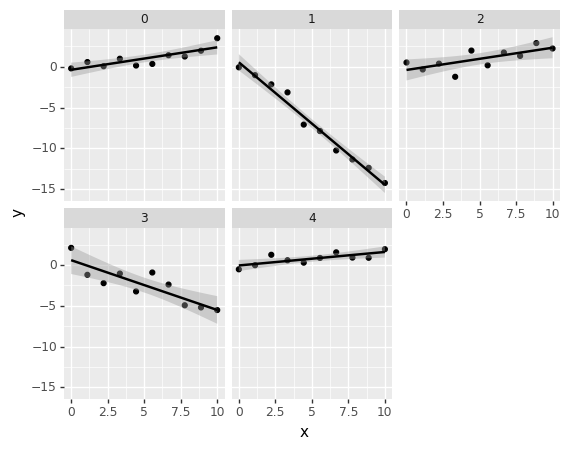

<ggplot: (346932373)>

In [98]:
(ggplot(df, aes('x', 'y')) +
geom_point() + 
 geom_smooth(method='lm') +
facet_wrap('id'))

Use a linear regression where all data are pooled. Create a method which extracts the slope coefficient.

In [107]:
model = sm.OLS(df['y'], df['x'])
fit = model.fit()

In [137]:
fit.params[0]
fit.tvalues[0]
fit.pvalues[0]

0.005801514037226713

# Time series regression

Write a function which generates data as per an autoregressive process:

$X_t = \rho X_{t-1} + \epsilon_t,$

where $\epsilon_t \sim N(0, \sigma)$, $X_0=0$ and $t=1,...,T$.

Your function should take as arguments: $\rho$, $T$ and $\sigma$. Note that here we are assuming $0\leq\rho\leq 1$.

In [131]:
def ar1(rho, T, sigma):
    X = [0]
    for t in range(1, T):
        X_t = np.random.normal(rho * X[t - 1], sigma, 1)[0]
        X.append(X_t)
    return X

Plot a few realisations of the process. What happens as you change $\rho$?

Low $\rho$: the process is a mean-reverting process.

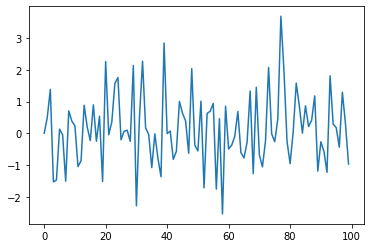

In [135]:
plt.plot(ar1(0, 100, 1))
plt.show()

High $\rho$: the process is a random walk (which is a non-stationary process).

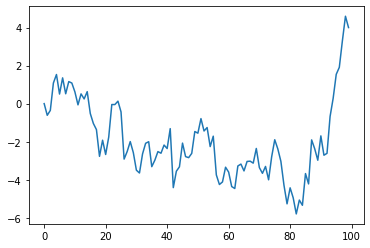

In [136]:
plt.plot(ar1(1, 100, 1))
plt.show()

Write a function which generates two (independent) ar1 processes, $\{X_t\}$ and $\{Y_t\}$ and performs a linear regression of one on the other:

$Y_t = \alpha + \beta X_t + \epsilon_t$

Let the function return both $\beta$ and the $p$-value associated with it.

In [152]:
def ar1_independent_regression(rho, T, sigma):
    X = ar1(rho, T, sigma)
    Y = ar1(rho, T, sigma)
    X = sm.add_constant(X, prepend=False)
    model = sm.OLS(Y, X)
    fit = model.fit()
    beta = fit.params[0]
    p = fit.pvalues[0]
    return beta, p

What value do you expect $\beta$ to be?

Answer: zero. The series are independent.

Suppose $\rho=0$. Carry out a 1000 regressions where $T=100$ and $\sigma=0.5$ using your above function, in each case storing the values of $\beta$ and the $p$-values.

In [186]:
def regression_iterates(niter, rho, T, sigma):
    betas = []
    ps = []
    for i in range(niter):
        beta, p = ar1_independent_regression(rho, T, sigma)
        betas.append(beta)
        ps.append(p)
    return betas, ps

rho = 0.0
T = 100
sigma = 0.5
niter = 1000
betas, ps = regression_iterates(niter, rho, T, sigma)

What's the mean value of $\beta$ across all the iterates?

Answer: should be near zero.

In [187]:
np.mean(betas)

-0.0044585490894393015

What are proportion of cases do you reject the null hypothesis at the $5\%$ level?

Answer: should be near the 5% level.

In [188]:
np.mean(np.array(ps) < 0.05)

0.064

Now repeat the exercise but assuming $\rho=1$. What's the mean $\beta$ value now?

In [189]:
rho = 1
betas, ps = regression_iterates(niter, rho, T, sigma)

In [190]:
np.mean(betas)

-0.015132503968140462

Now, what are proportion of cases do you reject the null hypothesis at the $5\%$ level?

In [191]:
np.mean(np.array(ps) < 0.05)

0.749

From this, what do you conclude about the statistical test?

Answer: when $\rho$ is near 1, linearly regressing two independent AR1 processes and using the standard $t$ scores to assess their significance generates an over-abundance of false positives.

Bonus question: what do you conclude about conducting regression analyses of time series data?

That you need to be careful when conducting regression using time series data. Specifically, you need to ensure that either the data are what are known as stationary; or that you use a method that accounts for the risk of spurious regression: see this video for an intuitive explanation of the concept: https://www.youtube.com/watch?v=eozA46jWBck

# Power analysis of interaction effects

Suppose that the value of a house, $H_i>0$, depends linearly on whether or its square footage, $S_i>0$ and whether it has a swimming pool, $P_i\in\{0,1\}$. Further, we believe that there is probably an interaction effect: if a house has a swimming pool, increases in its size have greater impacts on its price. One way to represent this relationship is via the below model:

$H_i = \alpha + \beta S_i + \gamma P_i + \delta P_i S_i + \epsilon_i$.

where $\epsilon_i\sim N(0, \sigma)$ represents a random error term.

Explain why this model allows such an interaction effect.

If $P_i=0$, then the average relationship is:

$H_i = \alpha + \beta S_i$.

If $P_i=1$, the relationship becomes:

$H_i = (\alpha + \gamma) + (\beta + \delta) S_i$.

In other words, $\delta$ effectively increases the slope, leading to a greater impact of changes in house size on its price.

Generate $(H_i, S_i, P_i)$ data for 100 houses by generating:

$S_i\sim N(0, 1)$

$P_i \sim \text{Bernoulli}(0.5)$,

with $\alpha=0$, $\beta=0.5$, $\gamma=0.5$, $\delta=0.1$, $\sigma=0.5$. (Note, here we are assuming scaled units for everything!)

In [202]:
def house_price(S, P, parameters):
    alpha = parameters['alpha']
    beta = parameters['beta']
    gamma = parameters['gamma']
    delta = parameters['delta']
    sigma = parameters['sigma']
    P = alpha + beta * S + gamma * P + delta * S * P + np.random.normal(0, sigma, 1)[0]
    return P

In [224]:
import scipy.stats
nhouses = 100
S = np.random.normal(0, 1, nhouses)
P = scipy.stats.bernoulli.rvs(0.5, 0, nhouses)
alpha = 0
beta = 0.5
gamma = 0.5
delta = 0.1
sigma = 0.5
parameters = {'alpha': alpha, 'beta': beta, 'gamma': gamma, 'delta': delta, 'sigma': sigma}
H = []
for i in range(nhouses):
    H.append(house_price(S[i], P[i], parameters))

Plot house price vs size for both those houses with and without swimming pools.

In [225]:
df = pd.DataFrame({'H': H, 'S': S, 'P': P})
df["P"] = df["P"].astype("category")

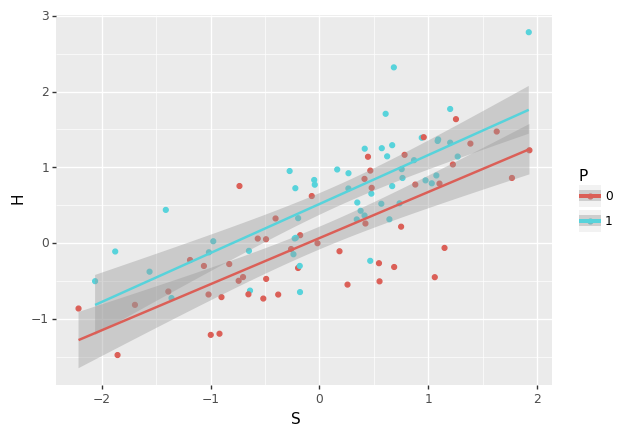

<ggplot: (349075565)>

In [226]:
(ggplot(df, aes('S', 'H', colour='P')) +
geom_point() +
geom_smooth(method='lm'))

Now write a function to perform the linear regression of the model. Your function should return the percentage error on $\beta$, $\gamma$ and $\delta$ versus their true values.

In [229]:
def percentage_error(estimate, true):
    

def house_regression(df, parameters):
    H = df["H"]
    X = df[["S", "P"]]
    X["SP"] = df["S"] * df["P"]
    X = sm.add_constant(X, prepend=False)
    model = sm.OLS(H, X)
    fit = model.fit()
    params = fit.params[0:3]
    
    # compare with true values
    beta = parameters['beta']
    gamma = parameters['gamma']
    delta = parameters['delta']
    
    return fit.summary()

In [231]:
df = pd.DataFrame({'H': H, 'S': S, 'P': P})
house_regression(df, parameters)

S     0.608441
P     0.449754
SP    0.038094
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      H   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     52.92
Date:                Wed, 09 Jun 2021   Prob (F-statistic):           2.82e-20
Time:                        17:08:38   Log-Likelihood:                -72.265
No. Observations:                 100   AIC:                             152.5
Df Residuals:                      96   BIC:                             163.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
S              0.6084      0.074      8.178      0.000       0.461       0.756
P              0.4498      0.103      4.362      0.000       0.245       0.654
SP             0.0381      0.112      0.340      0.735      -0.184       0.261
const          0.0656      0.073      0.903      0.369      -0.079       0.210
==============================================================================
Omnibus:                        0.071   Durbin-Watson:                   2.367
Prob(Omnibus):                  0.965   Jarque-Bera (JB):                0.191
Skew:                           0.055   Prob(JB):                        0.909
Kurtosis:                       2.817   Cond. No.                         2.98
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""